## Домашка 

### Задание 1 (8 баллов)
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на Recall@Precision меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import keras
print(keras.__version__)

3.8.0


In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv('lenta_40k.csv')

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [7]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [8]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [9]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [10]:
MEAN_LEN = np.median([len(x) for x in X])
MAX_LEN = int(MEAN_LEN + 30)

In [11]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)
X.shape

(44356, 200)

In [12]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [13]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [15]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [1,3,4,5,7,10]:
    conv1 = keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = keras.layers.Conv1D(kernel_size=ks, filters=24, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)

concat = keras.layers.concatenate(convs, axis=2)

conv_global1 = keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(concat)
conv_global2 = keras.layers.Conv1D(kernel_size=6, filters=26, strides=1, activation='relu')(conv_global1)
pool = keras.layers.AveragePooling1D(pool_size=3)(conv_global2)
dropout = keras.layers.Dropout(rate = 0.4)(pool)
flatten = keras.layers.Flatten()(dropout)
dense = keras.layers.Dense(50, activation='relu')(flatten)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 100)  │  2,409,200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 200, 32)   │      3,232 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 200, 32)   │      9,632 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 200, 32)   │     12,832 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 200, 32)   │     16,032 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 200, 32)   │     22,432 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 200, 32)   │     32,032 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 200, 24)   │        792 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 200, 24)   │      2,328 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 200, 24)   │      3,096 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 200, 24)   │      3,864 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 200, 24)   │      5,400 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 200, 24)   │      7,704 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200, 144)  │          0 │ conv1d_1[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_7[0][0],   │
│                     │                   │            │ conv1d_9[0][0],   │
│                     │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 198, 32)   │     13,856 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 193, 26)   │      5,018 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d   │ (None, 64, 26)    │          0 │ conv1d_13[0][0]   │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 26)    │          0 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1664)      │          0 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50)        │     83,250 │ flatten[0][0]   

 Total params: 2,631,669 (10.04 MB)

 Trainable params: 2,631,669 (10.04 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла 
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

In [18]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks = [checkpoint, early_stop])

Epoch 1/10


c:\Users\Alex\scoop\apps\python\3.12.6\Lib\site-packages\keras\src\backend\torch\nn.py:466: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1032.)
  outputs = tnn.conv1d(


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.6854 - rec@prec: 3.4091e-05
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 1.6792 - rec@prec: 3.2609e-05 - val_loss: 1.2301 - val_rec@prec: 0.0000e+00
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.1219 - rec@prec: 7.1187e-05
Epoch 2: val_rec@prec improved from 0.00000 to 0.02525, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 1.1179 - rec@prec: 6.9124e-05 - val_loss: 0.8207 - val_rec@prec: 0.0252
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.7449 - rec@prec: 0.0940
Epoch 3: val_rec@prec improved from 0.02525 to 0.27232, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.7422 - rec@prec: 0.0970 - val_loss: 0.5507 - val_rec@prec: 0.2723
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.4990 - rec@prec: 0.3951
Epoch 4: val_rec@prec improved from 0.27232 to 0.3

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


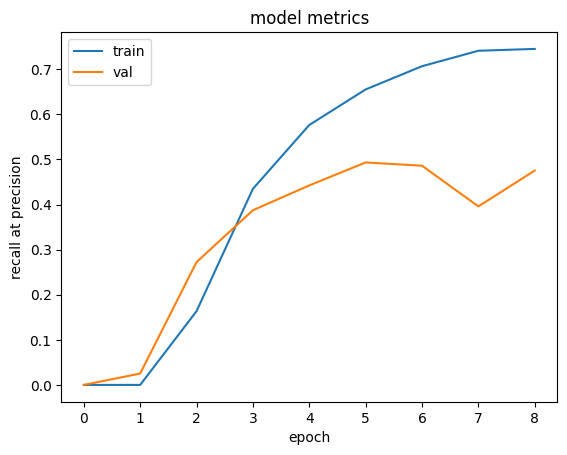

In [20]:
print(model.history.history.keys())

plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



### Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности с помощью CNN, а затем обратное увеличение длины последовательности до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями. 
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже. 

Для повышения размерности используйте keras.layers.UpSampling1D
Полученная модель должна давать ненулевое качество на той же самой задаче классификации текстов.

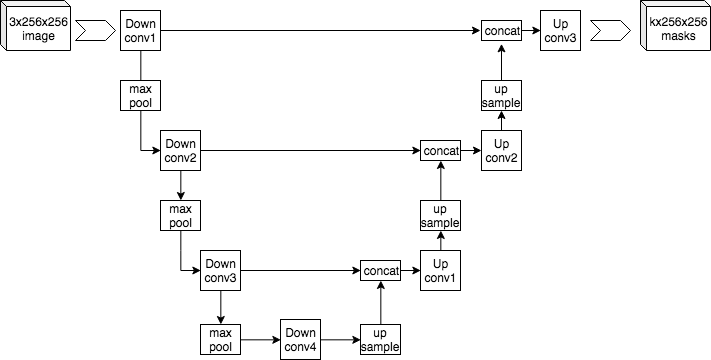

In [76]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

down_conv1 = keras.layers.Conv1D(kernel_size=3, filters=64, strides=1, padding='same')(embeddings)
pool1 = keras.layers.MaxPooling1D(pool_size=2)(down_conv1)

down_conv2 = keras.layers.Conv1D(kernel_size=3, filters=32, strides=1,padding='same')(pool1)
pool2 = keras.layers.MaxPooling1D(pool_size=2)(down_conv2)

down_conv3 = keras.layers.Conv1D(kernel_size=3, filters=16, strides=1, padding='same')(pool2)
pool3 = keras.layers.MaxPooling1D(pool_size=2)(down_conv3)

down_conv4 = keras.layers.Conv1D(kernel_size=3, filters=8, strides=1, padding='same')(pool3)

up1 = keras.layers.UpSampling1D(size=2)(down_conv4)

concat1 = keras.layers.concatenate((up1, down_conv3), axis=2)

up_conv1 = keras.layers.Conv1D(kernel_size=3, filters=8, strides=1, padding='same')(concat1)
up2 = keras.layers.UpSampling1D(size=2)(up_conv1)

concat2 = keras.layers.concatenate((up2, down_conv2), axis=2)

up_conv2 = keras.layers.Conv1D(kernel_size=3, filters=32, strides=1, padding='same')(concat2)
up3 = keras.layers.UpSampling1D(size=2)(up_conv2)

concat3 = keras.layers.concatenate((up3, down_conv1), axis=2)
up_conv3 = keras.layers.Conv1D(kernel_size=3, filters=32, strides=1, padding='same')(concat3)

flatten = keras.layers.Flatten()(up_conv3)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(flatten)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [77]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_40        │ (None, 200, 100)  │  2,409,200 │ input_layer_40[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_207 (Conv1D) │ (None, 200, 64)   │     19,264 │ embedding_40[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_114   │ (None, 100, 64)   │          0 │ conv1d_207[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_208 (Conv1D) │ (None, 100, 32)   │      6,176 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_115   │ (None, 50, 32)    │          0 │ conv1d_208[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_209 (Conv1D) │ (None, 50, 16)    │      1,552 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_116   │ (None, 25, 16)    │          0 │ conv1d_209[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_210 (Conv1D) │ (None, 25, 8)     │        392 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_60    │ (None, 50, 8)     │          0 │ conv1d_210[0][0]  │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_57      │ (None, 50, 24)    │          0 │ up_sampling1d_60… │
│ (Concatenate)       │                   │            │ conv1d_209[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_211 (Conv1D) │ (None, 50, 8)     │        584 │ concatenate_57[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_61    │ (None, 100, 8)    │          0 │ conv1d_211[0][0]  │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_58      │ (None, 100, 40)   │          0 │ up_sampling1d_61… │
│ (Concatenate)       │                   │            │ conv1d_208[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_212 (Conv1D) │ (None, 100, 32)   │      3,872 │ concatenate_58[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling1d_62    │ (None, 200, 32)   │          0 │ conv1d_212[0][0]  │
│ (UpSampling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_59      │ (None, 200, 96)   │          0 │ up_sampling1d_62… │
│ (Concatenate)       │                   │            │ conv1d_207[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_213 (Conv1D) │ (None, 200, 32)   │      9,248 │ concatenate_59[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 6400)      │          0 │ conv1d_213[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,571,907 (9.81 MB)

 Trainable params: 2,571,907 (9.81 MB)

 Non-trainable params: 0 (0.00 B)

In [78]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [79]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks = [checkpoint, early_stop])

Epoch 1/10
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - loss: 0.1835 - rec@prec: 9.2769e-06
Epoch 1: val_rec@prec did not improve from 0.67313
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step - loss: 0.1827 - rec@prec: 1.6725e-05 - val_loss: 0.1572 - val_rec@prec: 0.0000e+00
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - loss: 0.1480 - rec@prec: 0.0157
Epoch 2: val_rec@prec did not improve from 0.67313
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 775ms/step - loss: 0.1475 - rec@prec: 0.0173 - val_loss: 0.1152 - val_rec@prec: 0.2196
Epoch 3/10
21/22 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1011 - rec@prec: 0.3861
Epoch 3: val_rec@prec did not improve from 0.67313
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.1004 - rec@prec: 0.3948 - val_loss: 0.0857 - val_rec@prec: 0.6078
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - loss: 0.0650 - rec@prec: 0.7381
Epoch 4: val_rec@prec did not improve from 0.67313
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 471ms/step - loss: 0.0648 - rec@prec: 0.7390 - val_loss: 0.08

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


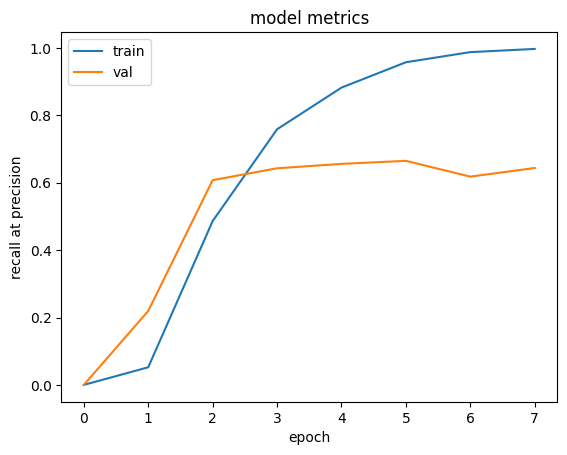

In [80]:
print(model.history.history.keys())

plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()